# Sentiment analysis of Bluesky posts

In [9]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Get Bluesky "skeets" and store them in a dataframe

In [10]:
from bluesky.search_bluesky import search_bluesky,search_bluesky_batch

# this shows how free days affect bluesky posts
df = search_bluesky_batch(query='Field Museum', since_date='2023-03-25', until_date='2024-09-11', nbatch=20)

# this shows how the Archaeopteryx reveal affected bluesky posts
# df = search_bluesky(query="'Field Museum'", since_date="2024-05-01", until_date="2024-05-12")

df.head()

Number of posts: 1
Number of posts: 8
Number of posts: 4
Number of posts: 16
Number of posts: 29
Number of posts: 34
Number of posts: 35
Number of posts: 44
Number of posts: 46
Number of posts: 41
Number of posts: 34
Number of posts: 28
Number of posts: 39
Number of posts: 32
Number of posts: 43
Number of posts: 47
Number of posts: 22
Number of posts: 36
Number of posts: 40
Number of posts: 58


,User,Content,Likes,Reposts,date
0,seashore.bsky.social,Beach day yesterday in Chicago but 40-ish toda...,1,0,2023-04-16 18:05:00
0,surrealistship.bsky.social,"One of my favorite tourist days I've ever had,...",3,0,2023-05-16 19:18:00
1,annierar.bsky.social,"For some internet nostalgia, the Field Museum ...",0,0,2023-05-16 00:17:00
2,restingdinoface.bsky.social,"All sauropods are impressive, but I love that ...",5,1,2023-05-15 13:07:00
3,dancredentials.bsky.social,Field museum should get them,0,0,2023-05-14 00:10:00


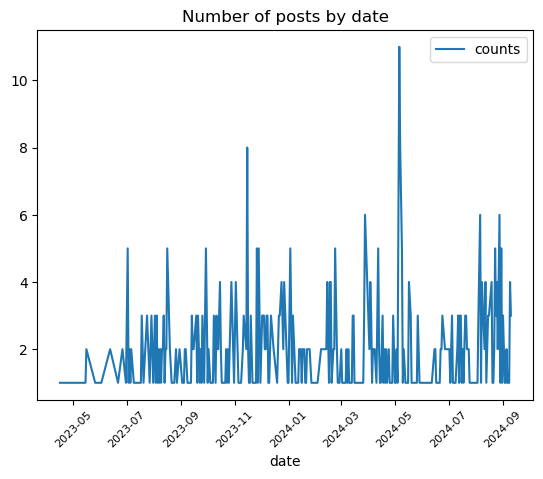

In [11]:
# Summarize number of rows by date
summary_by_date = df.groupby(df['date'].dt.date).size().reset_index(name='counts')
# print(summary_by_date)

summary_by_date.plot(x='date', y='counts', kind='line', title='Number of posts by date')
plt.xticks(rotation=45, fontsize=8)
plt.savefig('figs/timeline.png', dpi=300)

In [13]:
# Convert date2 to datetime if it's not already
df['date2'] = pd.to_datetime(df['date'])

# Reference date (e.g., the minimum date in the dataset)
ref_date = df['date2'].min()

# Convert date2 to float days since the reference date
df['date2_float'] = (df['date2'] - ref_date).dt.total_seconds() / (24 * 3600)

df['date2_float']

0       0.000000
0      30.050694
1      29.258333
2      28.793056
3      27.253472
         ...    
53    487.804861
54    487.728472
55    487.005556
56    486.863889
57    486.300694
Name: date2_float, Length: 637, dtype: float64

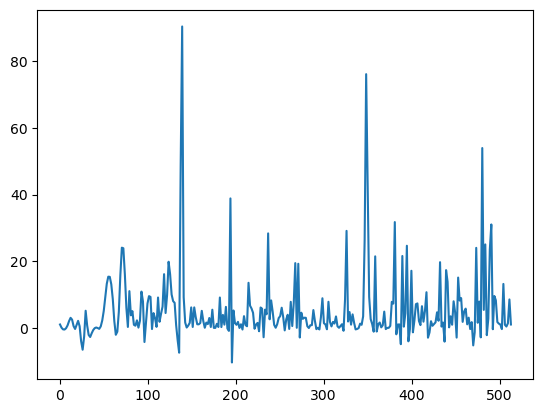

In [82]:
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

# Remove duplicates
xvar, unique_indices = np.unique(xvar, return_index=True)
yvar = yvar.iloc[unique_indices]

xnew = np.linspace(xvar.min(), xvar.max(), 300)

spl = make_interp_spline(xvar, yvar, k=2)

power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
# plt.plot(xvar, yvar, type='scatter')


In [14]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

There are 637 observations and 7 features in this dataset. 



## make a wordcloud

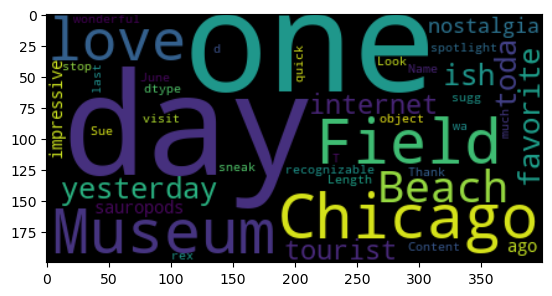

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = str(df.Content)

# text = text.replace('Field Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear')

plt.savefig('figs/wordcloud.png', dpi=300)


## sentiment analysis



In [195]:
# sentiment analysis functions

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re

def get_post_sentiment(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_value(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    return analysis.sentiment.polarity

def get_post_sentiment_vad(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    if vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_vad_value(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    return vs['compound']


In [41]:
df['Sentiment'] = df['Content'].apply(get_post_sentiment_vad)
df['Sentiment_value'] = df['Content'].apply(get_post_sentiment_vad_value)
df.head()

# save output
df.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

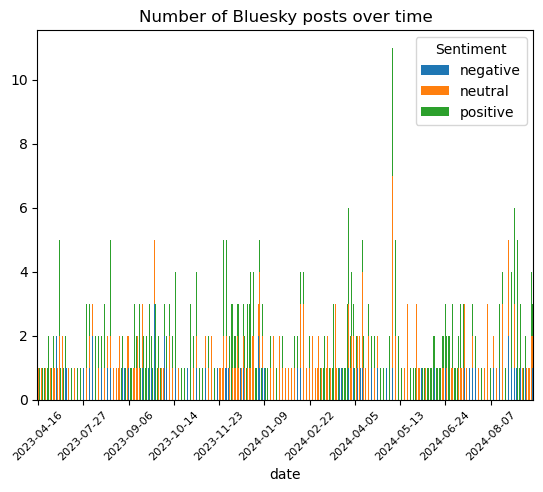

In [48]:
# now plot as a function of time and sentiment:

import seaborn as sns
import pandas as pd

# Summarize number of rows by date and sentiment
summary_by_date = df.groupby([df['date'].dt.date, 'Sentiment']).size().reset_index(name='counts')

# are there spikes on museum free days?
# print(summary_by_date.sort_values(by='counts', ascending=False))

# Line plot
# sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
# plt.xticks(rotation=45, fontsize=8)

# Bar plot
summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.xticks(rotation=45, fontsize=8)

plt.title('Number of Bluesky posts over time')

# Add horizontal lines every Wednesday
for date in pd.date_range(start=summary_by_date['date'].min(), end=summary_by_date['date'].max(), freq='W-WED'):
    plt.axvline(date, color='gray', linestyle='--', linewidth=0.5)

# plt.show()

# save figure
plt.savefig('figs/timeline_sentiment.png', dpi=300)


In [13]:
# summary_by_date.sort_values('counts', ascending=False)

df.groupby(df['date'].dt.date).size().sort_values(ascending=False)


date
2024-05-06    11
2023-11-15     8
2024-05-07     8
2024-08-06     6
2024-03-28     6
              ..
2024-01-12     1
2024-01-16     1
2024-01-20     1
2024-01-21     1
2024-01-27     1
Length: 329, dtype: int64

In [14]:
# Pivot the summary_by_month DataFrame
# Summarize counts by month
df['month'] = df['date'].dt.to_period('M')
summary_by_month = df.groupby([df['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

print(summary_by_month_wide)


Sentiment  negative  neutral  positive
month                                 
2023-04         0.0      2.0       1.0
2023-05         0.0      2.0       5.0
2023-06         2.0      3.0       2.0
2023-07         3.0     12.0      18.0
2023-08         9.0     14.0      19.0
2023-09         8.0     13.0      22.0
2023-10         9.0     14.0      26.0
2023-11         7.0     26.0      16.0
2023-12         2.0     17.0      24.0
2024-01         7.0     15.0      16.0
2024-02         3.0     20.0      17.0
2024-03         3.0     13.0      19.0
2024-04         8.0     20.0      17.0
2024-05         2.0     25.0      26.0
2024-06         3.0      4.0      20.0
2024-07         5.0     15.0      20.0
2024-08        10.0     27.0      29.0
2024-09         3.0      7.0       7.0


In [15]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted

,month,Sentiment,counts
46,2024-08,negative,10
10,2023-08,negative,9
16,2023-10,negative,9
13,2023-09,negative,8
34,2024-04,negative,8
19,2023-11,negative,7
25,2024-01,negative,7
43,2024-07,negative,5
7,2023-07,negative,3
28,2024-02,negative,3


In [16]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted

,month,Sentiment,counts
48,2024-08,positive,29
18,2023-10,positive,26
39,2024-05,positive,26
24,2023-12,positive,24
15,2023-09,positive,22
42,2024-06,positive,20
45,2024-07,positive,20
12,2023-08,positive,19
33,2024-03,positive,19
9,2023-07,positive,18


## Top-10 most "negative" posts

In [39]:
top_neg_posts = list(df[df['Sentiment'] == 'negative'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content'])

# Wrap the text and add new lines
top_neg_posts = [textwrap.fill(post, width=100) for post in top_neg_posts]

print("\n\n".join(top_neg_posts))


Having an existential crisis going through the Death Exhibit at the Field Museum.

Interesse an der Kultur der Zapoteken, Mixteken oder allgemein für das vorkoloniale Mexiko? Morgen
hält Gary M. Feinman vom Field Museum in Chicago einen Vortrag in Kiel über die neuesten
Forschungsergebnisse, die sich aus der Analyse von Obsidianfunden ergeben haben 👇  🏺

Nearly 1,000 Birds Die After Striking Chicago Building At least 961 birds died in one night in
Chicago after crashing into the windows of the McCormick Place Lakeside Center during the height of
the fall migration.  Gifted article  www.nytimes.com/2023/10/08/u...

The first dinosaur fossils were identified in 1824, which means that: George Washington (d 1799),
Napoleon Bonaparte (d 1821), Jane Austen (d 1817), Daniel Boone (d 1820), all died without knowing
that dinosaurs existed. 😢🦖

Just a woman and her juvenile Alamosaurus.  Titanosaurians have weird ass feet. I took reference
photos of Maximo's feet while at the Field Museum and ye

NB: many of these aren't really negative. I might want to think about training my own word2vec kinda model for predicting sentiments.

## Top-10 most positive posts

In [35]:
import textwrap

# Get the top-10 most positive posts
top_pos_posts = list(df[df['Sentiment'] == 'positive'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content'])

# Wrap the text and add new lines
top_pos_posts = [textwrap.fill(post, width=100) for post in top_pos_posts]

print("\n\n".join(top_pos_posts))


Hit the Field Museum, Schedd Aquarium, and Museum of Science and Industry today. They are listed
from best to worst with the last one far below the other two

I also recently saw Maximo the titanosaur at the Field Museum and it was so cool I cried a little.

I want my body tossed into a bin of flesh-eating beetles at the Field Museum, but they don't offer
that service, even though I've had a membership for decades.

I want my body put in a bin of flesh-eating beetles at the Field Museum, but they say they won't do
that even though I've been a member for decades. 🪲🪲🪲

Wish Sue from Chicago Field Museum was on bsky :-(

going to the field museum anyone want any dinosaur bones

He died doing what he loved.

So, I want to go to KORD to The Field Museum. To see the lions and the elephants. A simple weekend
trip. Museum, dinner, home.

Was reminded last night of the time when I was in NY for work and Stacey texted saying she was at an
event at the Field Museum and did I want to guess what sh

In [21]:
df['date2'] = df['date'].dt.date

df[df['date2'] == '2024-05-06']

# df.loc[47]['Content']

df.loc[47]

# text = df.loc[47]['Content']
# print(text)

# tb = TextBlob(text)
# tb.sentiment_assessments
# dir(tb)


User                                          boombutton.bsky.social
Content            The Field Museum has a small pod of narwhals i...
Likes                                                              2
Reposts                                                            0
date                                             2024-08-20 14:59:00
Sentiment                                                   positive
Sentiment_value                                               0.2714
month                                                        2024-08
date2                                                     2024-08-20
Name: 47, dtype: object

# Bristol data

## Load the daily visitor data

{'M Shed', 'The Red Lodge Museum', 'ROMAN-VILLA', 'Bristol Archives', 'Bristol Museum', 'Blaise Castle House Museum', 'The Georgian House Museum'}
1379


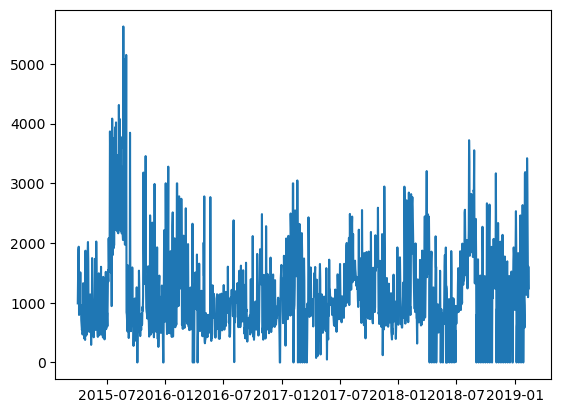

In [16]:
# loading museum visitor data - bristol museum
# https://opendata.bristol.gov.uk/datasets/98d95d36536343eca59e6e4bb04c58b7_0/explore

df2 = pd.read_csv('data/raw/Bristol_Museums_Daily_Visitor_Numbers.csv')

print(set(df2['Museum']))

df2 = df2[df2['Museum'] == 'Bristol Museum']

df2['Date'] = pd.to_datetime(df2['Date']).dt.date
# df2['date'] = df2['Date'].dt.date

df2.sort_values('Date', inplace=True)

print(len(df2))

# plt.scatter(df2['Date'], df2['Number_of_visitors'])

plt.plot(df2['Date'], df2['Number_of_visitors'])

# df2['Number_of_visitors'].groupby('Museum').aggregate(['min', 'max', 'mean', 'std'])
# df2.groupby('Museum').sum()


## Load tweets

In [17]:
# loading museum visitor data - field museum??
import glob

path = 'tweets'
filenames = glob.glob(path + "/bristol*.csv")

dfs = []
for f in filenames:
    df = pd.read_csv(f)
    dfs.append(df)

tweets = pd.concat(dfs, ignore_index=True)

# tweets.head()
len(tweets)



6281

### Remove self-tweets by the museum

In [18]:
tweets = tweets[tweets['Handle']!='@bristolmuseum']

print(len(tweets))
tweets.head()


3168


,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID
5,Rhian Rowson,@RhianRowson,2017-12-28T12:32:50.000Z,False,Virginia Woolf's fascination with insect life:...,0,13,24,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/606133212...,https://x.com/RhianRowson/status/9463582782163...,tweet_id:946358278216351744
9,RM,@RMAjayi,2017-12-27T12:30:01.000Z,False,"Thanks to a second photo from , I traced 1923 ...",2,1,2,0,[],['@zara_abd'],[],https://pbs.twimg.com/profile_images/971546387...,https://x.com/RMAjayi/status/945995181874171904,tweet_id:945995181874171904
14,Somaliland inBristol,@SLand_inBristol,2017-12-26T14:36:42.000Z,False,Never seen it before but you could approach st...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/731878241...,https://x.com/SLand_inBristol/status/945664672...,tweet_id:945664672040177665
15,Colin Moody,@MoodyColin,2017-12-26T13:54:59.000Z,False,Review of the year. February. Chinese New Year...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/147163090...,https://x.com/MoodyColin/status/94565417608801...,tweet_id:945654176088018945
20,Gary,@Garywalsh_,2017-12-24T21:05:44.000Z,False,absolutely loving the Bristol Museum Christma...,0,0,1,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/152847887...,https://x.com/Garywalsh_/status/94503780212276...,tweet_id:945037802122764289


### Plot tweets over time

In [43]:
# now we can plot the number of tweets and the number of visitors

tweets['date'] = pd.to_datetime(tweets['Timestamp']).dt.date

# tweets['date'][0:10]

tweets.groupby('date').aggregate('count')

# Summarize counts by date only if numeric
tweet_counts_by_date = tweets.groupby('date').size().reset_index(name='counts')
# tweet_counts_by_date

# Merge with visitor data
merged_data = pd.merge(df2, tweet_counts_by_date, left_on='Date', right_on='date', how='left')
# merged_data.head()

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['day'] = merged_data['date'].dt.day_name()

merged_data['weekend'] = [True if x in ['Saturday', 'Sunday'] else False for x in merged_data['day']]

merged_data.head()


,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,weekend
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,Wednesday,False
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,Thursday,False
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,Friday,False
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,Saturday,True
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,Sunday,True


In [44]:
# Plot the number of tweets and the number of visitors
# merged_data_2018 = merged_data[(merged_data['date'].dt.year == 2018) & (merged_data['weekend'] == True)]
merged_data_2018 = merged_data[merged_data['date'].dt.year == 2018]
merged_data_2018

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,weekend
981,Bristol Museum,visits,632.0,2018-01-01,NaN,2018/01/13 12:58:00.747+00,1522,2018-01-01,1.0,Monday,False
982,Bristol Museum,visits,1458.0,2018-01-02,NaN,2018/01/13 12:57:41.220+00,1516,2018-01-02,2.0,Tuesday,False
983,Bristol Museum,visits,1087.0,2018-01-03,NaN,2018/01/13 12:57:21.019+00,1505,2018-01-03,3.0,Wednesday,False
984,Bristol Museum,visits,891.0,2018-01-04,NaN,2018/01/13 12:56:46.745+00,1497,2018-01-04,2.0,Thursday,False
985,Bristol Museum,visits,866.0,2018-01-05,NaN,2018/01/13 12:55:18.019+00,1489,2018-01-05,1.0,Friday,False
...,...,...,...,...,...,...,...,...,...,...,...
1329,Bristol Museum,visits,0.0,2018-12-26,NaN,2019/02/12 12:20:29.169+00,59,2018-12-26,2.0,Wednesday,False
1330,Bristol Museum,visits,1206.0,2018-12-27,NaN,2018/12/30 14:51:24.702+00,58,2018-12-27,1.0,Thursday,False
1331,Bristol Museum,visits,1715.0,2018-12-28,NaN,2018/12/30 14:50:50.236+00,55,2018-12-28,2.0,Friday,False
1332,Bristol Museum,visits,1927.0,2018-12-29,NaN,2018/12/30 14:50:13.348+00,51,2018-12-29,3.0,Saturday,True


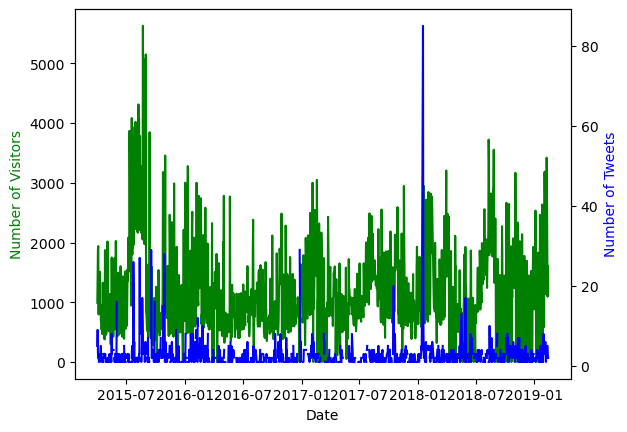

In [138]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data['Date'], merged_data['Number_of_visitors'], 'g-')
ax2.plot(merged_data['Date'], merged_data['counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of Tweets', color='b')

plt.show()

# spikey- are those weekends?



<Axes: xlabel='Number_of_visitors', ylabel='counts'>

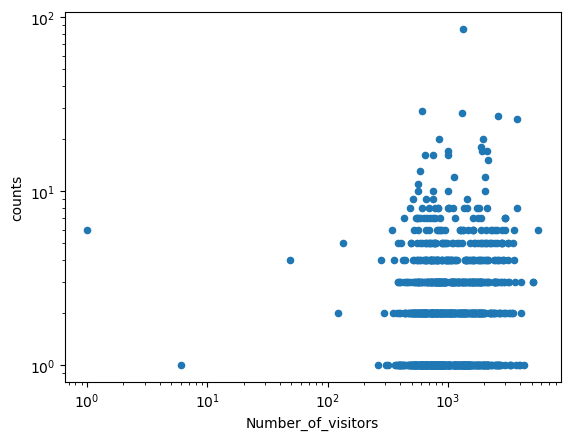

In [146]:
merged_data_clim.plot(x='Number_of_visitors', y='counts', kind='scatter', loglog=True)

In [46]:
# See what's causing the big spike in Jan. 2018
merged_data.sort_values('counts', ascending=False)
# merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,weekend
993,Bristol Museum,visits,1342.0,2018-01-17,the counter stopped at 4pm,2018/01/20 14:48:26.611+00,1408,2018-01-17,85.0,Wednesday,False
167,Bristol Museum,visits,607.0,2015-09-17,NaN,2017/05/10 14:50:56.010+00,5842,2015-09-17,29.0,Thursday,False
634,Bristol Museum,visits,0.0,2016-12-26,NaN,2017/05/10 14:50:57.757+00,2839,2016-12-26,29.0,Monday,False
208,Bristol Museum,visits,1315.0,2015-10-28,NaN,2017/05/10 14:50:56.163+00,5760,2015-10-28,28.0,Wednesday,False
131,Bristol Museum,visits,2627.0,2015-08-12,NaN,2017/05/10 14:50:55.875+00,6154,2015-08-12,27.0,Wednesday,False
...,...,...,...,...,...,...,...,...,...,...,...
1342,Bristol Museum,visits,0.0,2019-01-07,NaN,2019/02/12 12:22:44.769+00,174,NaT,NaN,NaN,False
1344,Bristol Museum,visits,693.0,2019-01-09,NaN,2019/01/12 12:05:37.022+00,171,NaT,NaN,NaN,False
1348,Bristol Museum,visits,1539.0,2019-01-13,NaN,2019/01/20 09:31:30.978+00,163,NaT,NaN,NaN,False
1350,Bristol Museum,visits,895.0,2019-01-15,NaN,2019/01/29 14:19:43.615+00,159,NaT,NaN,NaN,False


In [204]:
# tweets[tweets['date'] == '2018-01-17']
# tweets

merged_data.to_csv('data/processed/bristol_museum_tweets_visitors.csv', index=False)

# TODO: maybe start the script here, and put all the stuff above into a processing py script

In [23]:
from datetime import datetime as dt

start_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
end_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
# end_date = '2018-01-31'

filtered_tweets = tweets[(tweets['date'] >= start_date) & (tweets['date'] <= end_date)]

# Seems that the museum sold a Banksy print without that rights and that caused the spike in tweets that day
set(filtered_tweets['Content'])



{'  #fdlx #Bristol Museum sold unauthorised Banksy angel prints #News',
 ' Good Morning Bristol Museum! We love suggesting attractions to visit & would love it if you could follow us back. ',
 '#Bristol #Museum sold unauthorised #Banksy angel prints http://bbc.co.uk/news/uk-england-bristol-42708000…',
 'A #Bristol museum which produced prints of this #Banksy artwork, and sold more than 1,000 in a day, did not have permission to do so.\n\nMORE: http://bbc.in/2mECl9y',
 'BBC News - Bristol Museum sold unauthorised Banksy angel prints http://bbc.co.uk/news/uk-england-bristol-42708000…',
 'BBC News - Bristol Museum sold unauthorised Banksy prints http://bbc.co.uk/news/uk-england-bristol-42708000… - an object lesson in why galleries need to sort out their permissions in advance',
 'BBC News Bristol Museum sold unauthorised Banksy angel prints BBC News A… https://goo.gl/fb/qirmJJ #museum #news',
 'BBC News reporting that The Bristol Museum has been selling unauthorised prints of a Banksy scu

In [ ]:
# Get weather data
from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt



# Set time period
start = datetime(2014, 1, 1)
end = datetime(2019, 12, 31)

lat = 51.454514
lon = -2.587910
alt = 36 # feet

# Create Point for Bristol
bristol = Point(lat, lon, alt)

# Get daily data for 2014-2019
data = Daily(bristol, start, end)
data = data.fetch()

data.to_csv('data/processed/climate_bristol.csv')

# lyneham has precipitation data-
data = Daily('03740', start, end)
data = data.fetch()
data.head()

data.to_csv('data/processed/climate_lyneham.csv')


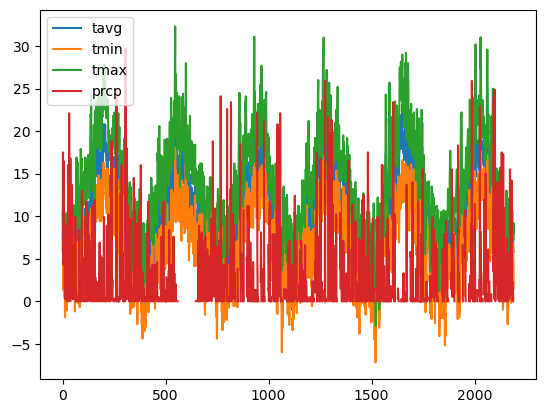

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

climdat = pd.read_csv('data/processed/climate_lyneham.csv')

# Plot line chart including average, minimum and maximum temperature
climdat.plot(y=['tavg', 'tmin', 'tmax','prcp'])
plt.show()


In [40]:
# add weather data to the merged data
# Convert 'time' column to datetime
climdat['time'] = pd.to_datetime(climdat['time']).dt.date
climdat['time']



0       2014-01-01
1       2014-01-02
2       2014-01-03
3       2014-01-04
4       2014-01-05
           ...    
2186    2019-12-27
2187    2019-12-28
2188    2019-12-29
2189    2019-12-30
2190    2019-12-31
Name: time, Length: 2191, dtype: object

In [47]:
# Merge weather data with the merged_data DataFrame
merged_data_clim = pd.merge(merged_data, climdat, left_on='Date', right_on='time', how='left')

merged_data_clim.head()




,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,Wednesday,...,6.3,2.6,9.9,0.5,NaN,268.0,25.0,NaN,1023.8,NaN
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,Thursday,...,7.9,5.2,9.8,1.5,NaN,225.0,14.1,NaN,1020.6,NaN
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,Friday,...,9.0,7.3,12.1,1.5,NaN,243.0,11.9,NaN,1016.5,NaN
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,Saturday,...,7.4,6.0,8.9,4.6,NaN,18.0,16.0,NaN,1023.0,NaN
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,Sunday,...,8.8,5.5,12.4,0.0,NaN,25.0,8.1,NaN,1027.2,NaN


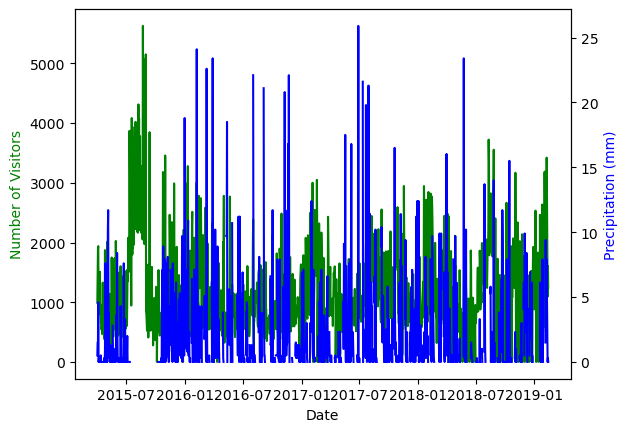

In [56]:
# Plot precipitation and visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['prcp'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.show()

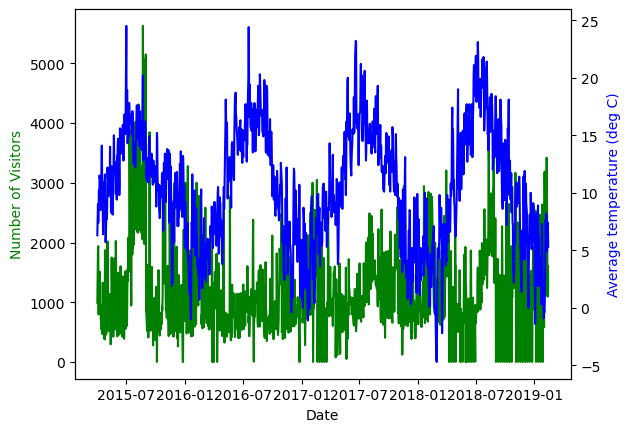

In [135]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Average temperature (deg C)', color='b')

plt.show()

In [73]:
# what other predictors?
# i want to make a predictive model of future trends 

# what about holidays?

# what about weekends?

# what about school holidays? NOT SURE

# what about special events?

# what about unique exhibitions?

# what about marketing campaigns?

# what about twitter sentiment? (might need to account for a lag here)

# what about the weather?
# DONE

# what about the day of the week?
print(set(merged_data_clim['day']))

# what about the month?
merged_data_clim['month'] = merged_data_clim['date'].dt.month
print(set(merged_data_clim['month']))
# what about the year?
merged_data_clim['year'] = merged_data_clim['date'].dt.year


merged_data_clim.head()

{'Tuesday', 'Thursday', 'Monday', nan, 'Sunday', 'Saturday', 'Wednesday', 'Friday'}
{1.0, 2.0, 3.0, 4.0, nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,year,month
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,Wednesday,...,9.9,0.5,NaN,268.0,25.0,NaN,1023.8,NaN,2015.0,4.0
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,Thursday,...,9.8,1.5,NaN,225.0,14.1,NaN,1020.6,NaN,2015.0,4.0
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,Friday,...,12.1,1.5,NaN,243.0,11.9,NaN,1016.5,NaN,2015.0,4.0
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,Saturday,...,8.9,4.6,NaN,18.0,16.0,NaN,1023.0,NaN,2015.0,4.0
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,Sunday,...,12.4,0.0,NaN,25.0,8.1,NaN,1027.2,NaN,2015.0,4.0


In [ ]:
# do sentiment analysis on the tweets


In [131]:
# do time series analysis?

# print(merged_data_clim.info())

merged_data_clim.columns

Index(['Museum', 'Kpi', 'Number_of_visitors', 'Date', 'Comments',
       'Date_Logged', 'ObjectId', 'date', 'counts', 'day', 'weekend', 'time',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'year', 'month'],
      dtype='object')

In [180]:
# Select relevant variables and drop NAs
selected_columns = ['date', 'Number_of_visitors', 'counts', 'day', 'month', 'weekend', 'tavg', 'prcp']
cleaned_data = merged_data_clim[selected_columns].dropna()
cleaned_data.head()

,date,Number_of_visitors,counts,day,month,weekend,tavg,prcp
0,2015-04-01,990.0,5.0,Wednesday,4.0,False,6.3,0.5
1,2015-04-02,1452.0,9.0,Thursday,4.0,False,7.9,1.5
2,2015-04-03,1894.0,3.0,Friday,4.0,False,9.0,1.5
3,2015-04-04,1939.0,2.0,Saturday,4.0,True,7.4,4.6
4,2015-04-05,796.0,3.0,Sunday,4.0,True,8.8,0.0


In [181]:
cleaned_data = pd.get_dummies(cleaned_data, columns=['month','day'])
# cleaned_data = pd.get_dummies(cleaned_data, columns=['weekend'])
# cleaned_data = pd.get_dummies(cleaned_data, columns=['day'])
cleaned_data

,date,Number_of_visitors,counts,weekend,tavg,prcp,month_1.0,month_2.0,month_3.0,month_4.0,...,month_10.0,month_11.0,month_12.0,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2015-04-01,990.0,5.0,False,6.3,0.5,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,2015-04-02,1452.0,9.0,False,7.9,1.5,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,2015-04-03,1894.0,3.0,False,9.0,1.5,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,2015-04-04,1939.0,2.0,True,7.4,4.6,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,2015-04-05,796.0,3.0,True,8.8,0.0,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2019-02-09,3421.0,2.0,True,6.2,7.9,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1375,2019-02-10,2843.0,5.0,True,4.9,5.3,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
1376,2019-02-12,1094.0,5.0,False,5.8,0.0,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1377,2019-02-13,1606.0,2.0,False,7.4,0.3,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [182]:
# partition the data

from sklearn.model_selection import train_test_split

# Randomly split 20% of rows as testing (or validation) and the other as training
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)
len(train_data), len(test_data)

(551, 138)

In [183]:
# Selecting columns for regressions
X_train = train_data.drop(columns=['date', 'Number_of_visitors'])
y_train = train_data['Number_of_visitors']

X_test = test_data.drop(columns=['date', 'Number_of_visitors'])
y_test = test_data['Number_of_visitors']


In [184]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Do decision tree regression
dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.13, random_state=3)
dtree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.13, random_state=3)

In [185]:
# Output R2, MSE for training and testing data-

# training data
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

# validation/testing data
pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))


540.9953525712083
0.35673067247294654
584.7024595551904
0.19959936999521444


In [186]:
# Fit a random forest regression model
model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100, max_depth = None)
model_rf.fit(X_train, y_train) 

RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)

In [187]:
# extract R2, model fits
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

192.07231589377884
0.9189159708838687
534.8607795595484
0.33024018553227097


R2 = 91.9% - not bad??

R2 for test data is low tho- 33%

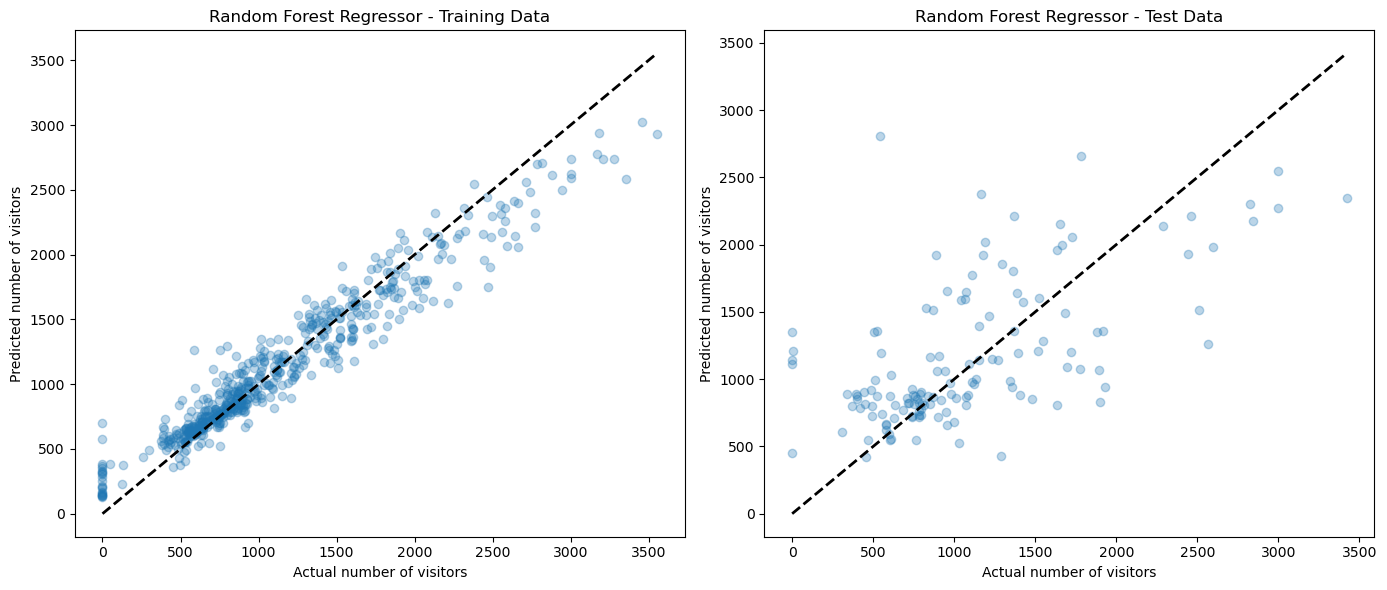

In [188]:

# Plotting the training data predictions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Training Data')

# Plotting the test data predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Test Data')

plt.tight_layout()
plt.show()

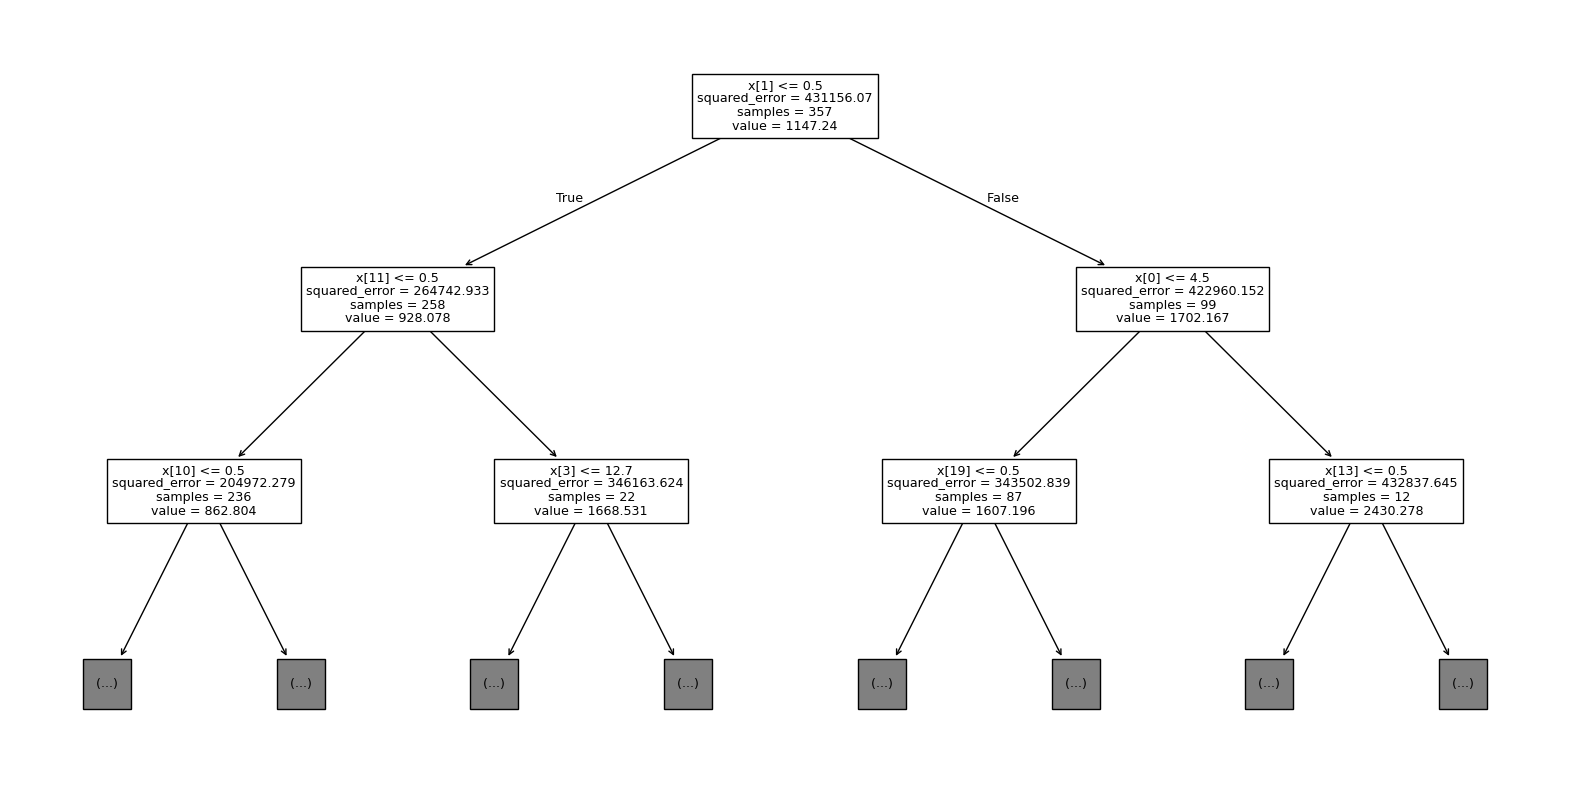

In [189]:
from sklearn import tree
plt.figure(figsize=(20, 10))
tree.plot_tree(model_rf.estimators_[0], max_depth=2)
plt.show()
# model_rf.estimators_[0]


In [190]:
# Get feature importances
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

          Feature  Importance
1         weekend    0.286837
2            tavg    0.174550
3            prcp    0.129733
0          counts    0.080407
11      month_8.0    0.073788
15     month_12.0    0.029738
5       month_2.0    0.028582
18   day_Saturday    0.023815
17     day_Monday    0.023620
13     month_10.0    0.018143
10      month_7.0    0.017115
8       month_5.0    0.015935
7       month_4.0    0.015312
19     day_Sunday    0.014665
4       month_1.0    0.010841
22  day_Wednesday    0.009578
6       month_3.0    0.009547
20   day_Thursday    0.007692
21    day_Tuesday    0.007570
16     day_Friday    0.007295
9       month_6.0    0.006562
14     month_11.0    0.005755
12      month_9.0    0.002921


In [163]:
merged_data_clim['Number_of_visitors'].max()
# max number of visitors on a day

5628.0

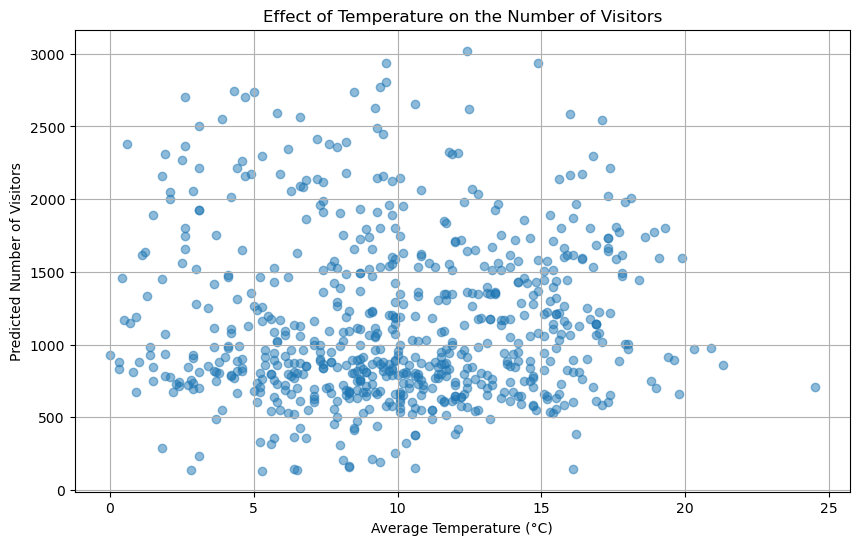

In [191]:
# Extract the temperature feature and the predicted number of visitors
temperature = cleaned_data['tavg']
predicted_visitors = model_rf.predict(cleaned_data.drop(columns=['date', 'Number_of_visitors']))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(temperature, predicted_visitors, alpha=0.5)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Predicted Number of Visitors')
plt.title('Effect of Temperature on the Number of Visitors')
plt.grid(True)
plt.show()

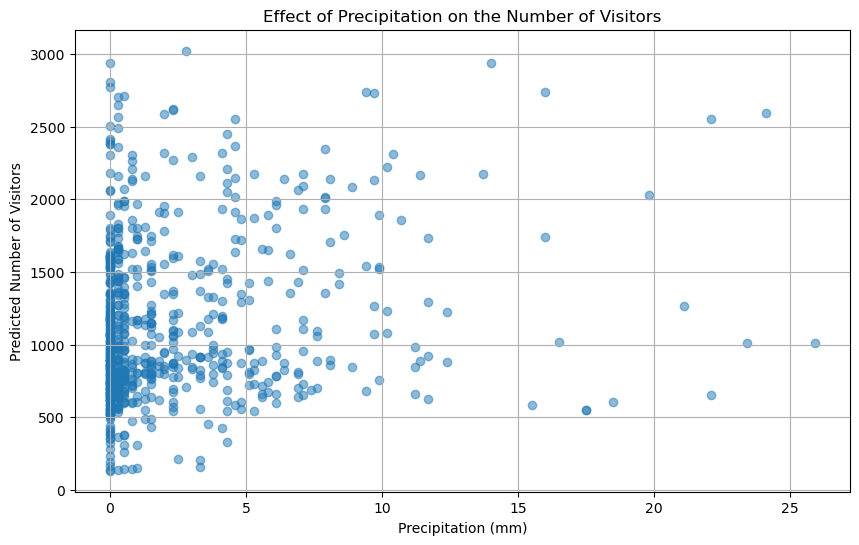

In [165]:
# this temp effect doesn't seem that strong
# maybe we need to look at the interaction between temp and other variables

# Extract the precipitation feature and the predicted number of visitors
precipitation = cleaned_data['prcp']
predicted_visitors = model_rf.predict(cleaned_data.drop(columns=['date', 'Number_of_visitors']))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(precipitation, predicted_visitors, alpha=0.5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Predicted Number of Visitors')
plt.title('Effect of Precipitation on the Number of Visitors')
plt.grid(True)
plt.show()


[Text(0.6, 0.9, 'node #0\nweekend <= 0.5\nsquared_error = 454982.01\nsamples = 551\nvalue = 1137.525'),
 Text(0.4, 0.7, 'node #1\ntavg <= 12.75\nsquared_error = 268058.678\nsamples = 390\nvalue = 902.549'),
 Text(0.5, 0.8, 'True  '),
 Text(0.3, 0.5, 'node #2\nprcp <= 1.4\nsquared_error = 212506.565\nsamples = 274\nvalue = 814.42'),
 Text(0.2, 0.3, 'node #3\ntavg <= 7.95\nsquared_error = 193806.543\nsamples = 169\nvalue = 768.964'),
 Text(0.1, 0.1, 'node #4\nsquared_error = 210900.944\nsamples = 72\nvalue = 790.264'),
 Text(0.3, 0.1, 'node #5\nsquared_error = 180531.224\nsamples = 97\nvalue = 753.155'),
 Text(0.4, 0.3, 'node #6\nsquared_error = 233926.567\nsamples = 105\nvalue = 887.581'),
 Text(0.5, 0.5, 'node #7\nsquared_error = 337597.652\nsamples = 116\nvalue = 1110.716'),
 Text(0.8, 0.7, 'node #8\nday_Sunday <= 0.5\nsquared_error = 450046.301\nsamples = 161\nvalue = 1706.72'),
 Text(0.7, 0.8, '  False'),
 Text(0.7, 0.5, 'node #9\nsquared_error = 422824.938\nsamples = 82\nvalue = 19

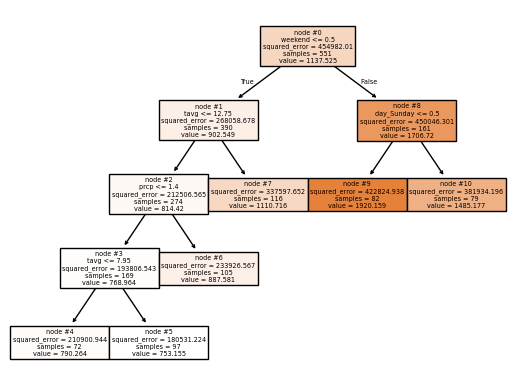

In [194]:
from sklearn import tree

import matplotlib.pyplot as plt

# Get the feature names
feature_names = X_train.columns

# Find the indices of the nodes that involve the 'prcp' feature
prcp_indices = [x == 'prcp' for x in feature_names]
# prcp_indices



# Plot the tree with only the nodes involving 'prcp'
# plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=feature_names, max_depth=5, filled=True, node_ids=True)
# plt.show()